#Imports and Download custom dataset
1.Custom Dataset download from this [this](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)
2. Basic Imports 

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score
import random
import numpy as np
import tensorflow as tf
from numpy.random import randint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from google.colab.patches import cv2_imshow
import tensorflow_datasets as tfds
%matplotlib inline
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip /content/trainPart1.zip

#Preprocessing
- ```bounder```: This function extracts the region of interest around the digit/character, since the characters do not fill the entire image
- In the next code block we iterate over the directories and for the supervised examples X and Y. 
- The following preprocessing has been applied to the image
  1. Image is converted to grayscale
  2. pixels are inverted thorugh ``cv2_bitwise``
  3. Images are resized to uniform shape of ``input_shape=(64,64)``
  4. Edges are smoothened using Gaussian Blur
  5. Label vector of dimension ``classes=10`` is formed, for 0-9 digit

In [ ]:
input_shape=(28,28,1) 
par_dir="/content/train"
classes=10
dicti={}

In [ ]:
def bounder(thresh,margin=12):
  sh=thresh.shape
  x_min,x_max,y_min,y_max=10000,-10000,10000,-10000
  for x in range(sh[0]):
    if np.amax(thresh[x])!=0: x_min,x_max=min(x_min,x),max(x_max,x)
  for y in range(sh[1]):
    if np.amax(thresh.T[y])!=0: y_min,y_max=min(y_min,y),max(y_max,y)
  return thresh[max(x_min-margin,0):min(x_max+margin,sh[1]),max(y_min-margin,0):min(y_max+margin,sh[1])]

In [ ]:
X,Y = [],[]
for foldername in os.listdir(par_dir):
  if int(foldername[-2:])-1>9: continue
  for filename in os.listdir(par_dir+"/"+str(foldername)):
    filepath=par_dir+"/"+str(foldername)+"/"+str(filename)
    image=cv2.imread(filepath)
    thresh = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_not(thresh)
    thresh=cv2.GaussianBlur(cv2.resize(bounder(thresh,24),(28,28)), (3, 3), 0)
    X.append(thresh)
    vec=np.zeros(classes)
    dicti[int(foldername[-2:])-1]=thresh
    vec[int(foldername[-2:])-1]=1
    Y.append(vec) 
X=np.expand_dims(np.array(X),3)
Y=np.array(Y)

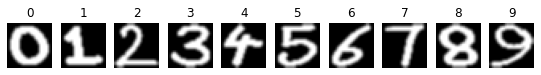

In [ ]:
plt.figure(figsize=(20,4))
for i,k in enumerate(sorted(dicti.keys())):
  plt.subplot(3,21,i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(dicti[k]),'gray')
  plt.title(str(k))

#Training on 0-9 digits from custom dataset

### Model
1. A 70-30 split is performed in the dataset
2. We define a keras data augmenter, ```ImageDataGenerator``` which will augment images on the fly. We resort to only rotating the images.
3. The same Modified LeNet model used earlier for training 62 classes, is used

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.30)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=False)
datagen.fit(X_train)

(280, 28, 28, 1) (280, 10) (120, 28, 28, 1) (120, 10)


In [ ]:
training =True

In [ ]:
!
def CustomCNN_arch(input_shape = (64, 64, 1), classes = 10):
  model = tf.keras.Sequential([
  Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = input_shape),
  Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),  
  BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25), 
  Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
  Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
  BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25),
  Flatten(name = 'flatten'),
  Dense(units = 256), BatchNormalization(), Activation("relu"),  
  Dense(units = 128), BatchNormalization(), Activation("relu"),
  Dropout(0.25),
  Dense(units = classes, activation = 'softmax')])
  return model
checkpoint_filepath = '/content/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                                               monitor='val_accuracy', mode='max', save_best_only=True)
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 7)
if training:
  model = CustomCNN_arch(input_shape = input_shape, classes = classes)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(datagen.flow(X_train, Y_train, batch_size=32),
            steps_per_epoch=len(X_train) / 32, epochs=100,
            callbacks = [variable_learning_rate,model_checkpoint_callback], validation_data = (X_test,Y_test)) 


Epoch 1/100
8/8 [==============================] - 31s 120ms/step - loss: 2.5361 - accuracy: 0.1339 - val_loss: 4.7475 - val_accuracy: 0.1417
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 1.6301 - accuracy: 0.4202 - val_loss: 4.2158 - val_accuracy: 0.1917
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 1.2551 - accuracy: 0.5396 - val_loss: 4.2155 - val_accuracy: 0.2417
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 1.0310 - accuracy: 0.6411 - val_loss: 4.6001 - val_accuracy: 0.2833
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.9630 - accuracy: 0.6901 - val_loss: 4.3917 - val_accuracy: 0.2750
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.8498 - accuracy: 0.7269 - val_loss: 2.6589 - val_accuracy: 0.4083
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.7614 - accuracy: 0.7606 - val_loss: 1.5682 - val_accuracy: 0.6167
Epoch 8/100
8/8 [=